# k-Nearest Neighbor (kNN) exercise

In [107]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# Load the raw CIFAR-10 data.
cifar10_dir = "cs231n/datasets/cifar-10-batches-py"
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


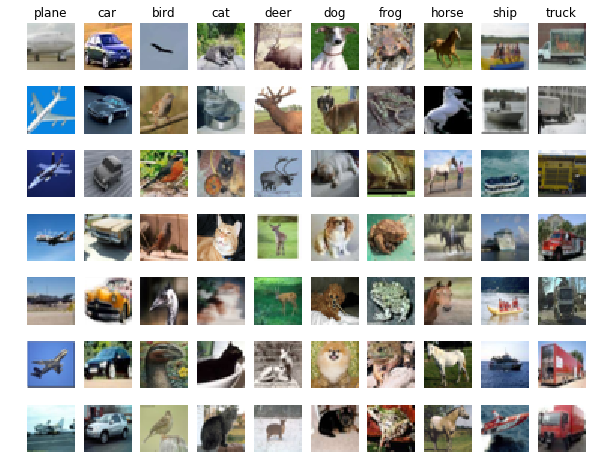

In [109]:
# Visualize some examples from the dataset.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [110]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [111]:
# Reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [112]:
from cs231n.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Relevant code is in `cs231n/classifiers/k_nearest_neighbor.py`.

In [113]:
# Compute the distance matrix with two loops.
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


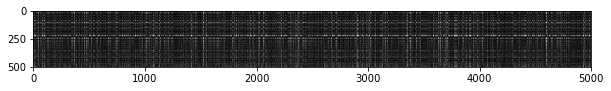

In [25]:
# Visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation="none")
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: 

Distinctly bright rows are test images that are far away from many training images (high L2 distance).

White columns are  training images that are far away from many test images (high L2).

Black columns are training images that are close to many test images (low L2).

In [114]:
# Predict labels for each test example based on 1 nearest neighbor.
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [115]:
# Repeat with k = 5.
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [116]:
# Repeat with partial vectorisation (one-loop) implementation.
dists_one = classifier.compute_distances_one_loop(X_test)

# Comparison with naive implementation based with Frobenius norm (matrix Euclidian distance).
difference = np.linalg.norm(dists - dists_one, ord="fro")
print("Difference was: %f" % (difference, ))
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

Difference was: 0.000000
Good! The distance matrices are the same


In [117]:
# Repeat with fully vectorised computation.
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord="fro")
print("Difference was: %f" % (difference, ))
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

Difference was: 0.000000
Good! The distance matrices are the same


In [74]:
# Let"s compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print("Two loop version took %f seconds" % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print("One loop version took %f seconds" % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print("No loop version took %f seconds" % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 25.499515 seconds
One loop version took 22.824696 seconds
No loop version took 0.167685 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [118]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(classifier.X_train, num_folds)
y_train_folds = np.array_split(classifier.y_train, num_folds)

# Dictionary storing accuracies for 5 folds across each value of k.
k_to_accuracies = {}

# k-fold cross validation to find the best value of k. 
for k_choice in k_choices:
    for i in range(num_folds):
        # Extract the training and test sets for the fold.
        X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        X_test_fold = X_train_folds[i]
        y_test_fold = y_train_folds[i]
        
        # Instantiate the classifier and compute the distance matrix.
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        
        # Predict labels based on the k-nearest neighbours and compute the number of correct predictions.
        y_test_pred = classifier.predict(X_test_fold, k_choice, 0)
        num_correct = np.sum(y_test_pred == y_test_fold)
        
        # Add the accuracy for that fold to the dictionary for that value of k.
        if k_choice in k_to_accuracies: k_to_accuracies[k_choice] += [float(num_correct) / float(len(y_test_fold))]
        else: k_to_accuracies[k_choice] = [float(num_correct) / float(len(y_test_fold))]

# Print out the computed accuracies.
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("k = %d, accuracy = %f" % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

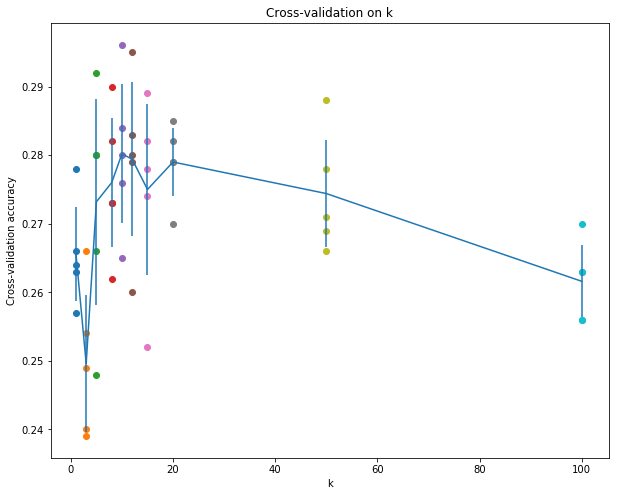

In [119]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title("Cross-validation on k")
plt.xlabel("k")
plt.ylabel("Cross-validation accuracy")
plt.show()

In [122]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
